# Dementia Modeling

## Data Set Loading / Exploratory Data Analysis

In [1]:
# Import dependencies
from sklearn.model_selection import train_test_split 
from sklearn.preprocessing import StandardScaler 
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import cross_val_score, StratifiedKFold
from sklearn.metrics import accuracy_score
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from sklearn.metrics import accuracy_score, roc_auc_score
from sklearn.decomposition import PCA
import xgboost as xgb
from datetime import datetime
# import tensorflow as tf
import pandas as pd
from scipy import stats
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# Read in and display csv to dataframe
df = pd.read_csv('Resources/dementia_patients_health_data.csv')
df.head()

,Diabetic,AlcoholLevel,HeartRate,BloodOxygenLevel,BodyTemperature,Weight,MRI_Delay,Prescription,Dosage in mg,Age,...,Smoking_Status,APOE_ε4,Physical_Activity,Depression_Status,Cognitive_Test_Scores,Medication_History,Nutrition_Diet,Sleep_Quality,Chronic_Health_Conditions,Dementia
0,1,0.084974,98,96.230743,36.224852,57.563978,36.421028,NaN,NaN,60,...,Current Smoker,Negative,Sedentary,No,10,No,Low-Carb Diet,Poor,Diabetes,0
1,0,0.016973,78,93.032122,36.183874,56.832335,31.157633,Galantamine,12.0,61,...,Former Smoker,Positive,Moderate Activity,No,1,Yes,Low-Carb Diet,Poor,Heart Disease,1
2,0,0.009000,89,93.566504,37.326321,59.759066,37.640435,NaN,NaN,69,...,Former Smoker,Negative,Moderate Activity,No,8,No,Mediterranean Diet,Poor,Heart Disease,0
3,0,0.086437,60,93.906510,37.030620,58.266471,50.673992,Donepezil,23.0,78,...,Never Smoked,Negative,Mild Activity,Yes,5,Yes,Balanced Diet,Poor,Hypertension,1
4,1,0.150747,67,97.508994,36.062121,67.705027,27.810601,Memantine,20.0,77,...,Never Smoked,Positive,Mild Activity,No,0,Yes,Low-Carb Diet,Good,Diabetes,1


### Data Cleaning / Data Engineering

In [3]:
# Check for missing values
df.isnull().sum()

Diabetic                       0
AlcoholLevel                   0
HeartRate                      0
BloodOxygenLevel               0
BodyTemperature                0
Weight                         0
MRI_Delay                      0
Prescription                 515
Dosage in mg                 515
Age                            0
Education_Level                0
Dominant_Hand                  0
Gender                         0
Family_History                 0
Smoking_Status                 0
APOE_ε4                        0
Physical_Activity              0
Depression_Status              0
Cognitive_Test_Scores          0
Medication_History             0
Nutrition_Diet                 0
Sleep_Quality                  0
Chronic_Health_Conditions    179
Dementia                       0
dtype: int64

In [4]:
# Replace missing dosage with 0
df['Dosage in mg'].fillna(0, inplace=True)

# Fill missing 'Prescription' values with None
df['Prescription'].fillna('None', inplace=True)

# Fill missing 'Prescription' values with None
df['Chronic_Health_Conditions'].fillna('None', inplace=True)

# Confirm changes
df.isnull().sum()

Diabetic                     0
AlcoholLevel                 0
HeartRate                    0
BloodOxygenLevel             0
BodyTemperature              0
Weight                       0
MRI_Delay                    0
Prescription                 0
Dosage in mg                 0
Age                          0
Education_Level              0
Dominant_Hand                0
Gender                       0
Family_History               0
Smoking_Status               0
APOE_ε4                      0
Physical_Activity            0
Depression_Status            0
Cognitive_Test_Scores        0
Medication_History           0
Nutrition_Diet               0
Sleep_Quality                0
Chronic_Health_Conditions    0
Dementia                     0
dtype: int64

In [5]:
# Determine the number of unique values in each column
df.nunique()

Diabetic                        2
AlcoholLevel                 1000
HeartRate                      41
BloodOxygenLevel             1000
BodyTemperature              1000
Weight                       1000
MRI_Delay                    1000
Prescription                    5
Dosage in mg                   11
Age                            31
Education_Level                 4
Dominant_Hand                   2
Gender                          2
Family_History                  2
Smoking_Status                  3
APOE_ε4                         2
Physical_Activity               3
Depression_Status               2
Cognitive_Test_Scores          11
Medication_History              2
Nutrition_Diet                  3
Sleep_Quality                   2
Chronic_Health_Conditions       4
Dementia                        2
dtype: int64

In [6]:
# Converting binary object features to 0's and 1's
df['Gender'] = df['Gender'].map({'Male': 1, 'Female': 0})
df["APOE_ε4"] = df["APOE_ε4"].map({'Positive': 1, 'Negative': 0})
df["Depression_Status"] = df["Depression_Status"].map({'Yes': 1, 'No': 0})
df["Sleep_Quality"] = df["Sleep_Quality"].map({'Good': 1, 'Poor': 0})
df["Dominant_Hand"] = df["Dominant_Hand"].map({'Left': 1, 'Right': 0})
df["Family_History"] = df["Family_History"].map({'Yes': 1, 'No': 0})
df["Medication_History"] = df["Medication_History"].map({'Yes': 1, 'No': 0})

In [7]:
# Display the dataframe shape
print("Dataframe shape:", df.shape)

# Dataframe dtypes
df.info()

# Display basic statistical details
df.describe()

Dataframe shape: (1000, 24)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 24 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Diabetic                   1000 non-null   int64  
 1   AlcoholLevel               1000 non-null   float64
 2   HeartRate                  1000 non-null   int64  
 3   BloodOxygenLevel           1000 non-null   float64
 4   BodyTemperature            1000 non-null   float64
 5   Weight                     1000 non-null   float64
 6   MRI_Delay                  1000 non-null   float64
 7   Prescription               1000 non-null   object 
 8   Dosage in mg               1000 non-null   float64
 9   Age                        1000 non-null   int64  
 10  Education_Level            1000 non-null   object 
 11  Dominant_Hand              1000 non-null   int64  
 12  Gender                     1000 non-null   int64  
 13  Family_History       

,Diabetic,AlcoholLevel,HeartRate,BloodOxygenLevel,BodyTemperature,Weight,MRI_Delay,Dosage in mg,Age,Dominant_Hand,Gender,Family_History,APOE_ε4,Depression_Status,Cognitive_Test_Scores,Medication_History,Sleep_Quality,Dementia
count,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.00000,1000.00000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000
mean,0.513000,0.098429,79.383000,95.226051,36.761513,74.321326,30.103568,4.468500,74.908000,0.519000,0.496000,0.52000,0.69400,0.245000,6.383000,0.514000,0.466000,0.485000
std,0.500081,0.058715,12.107556,2.929262,0.431701,14.463765,16.862170,6.453713,9.095068,0.499889,0.500234,0.49985,0.46106,0.430302,3.180633,0.500054,0.499092,0.500025
min,0.000000,0.000414,60.000000,90.010677,36.002108,50.069731,0.094684,0.000000,60.000000,0.000000,0.000000,0.00000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.045505,68.000000,92.875017,36.395363,61.387339,16.237371,0.000000,67.000000,0.000000,0.000000,0.00000,0.00000,0.000000,4.000000,0.000000,0.000000,0.000000
50%,1.000000,0.098235,79.000000,95.390420,36.784319,74.149204,29.577194,0.000000,75.000000,1.000000,0.000000,1.00000,1.00000,0.000000,8.000000,1.000000,0.000000,0.000000
75%,1.000000,0.151840,90.000000,97.785111,37.126655,87.024034,44.176723,8.000000,83.000000,1.000000,1.000000,1.00000,1.00000,0.000000,9.000000,1.000000,1.000000,1.000000
max,1.000000,0.199866,100.000000,99.999230,37.496809,99.982722,59.957599,23.000000,90.000000,1.000000,1.000000,1.00000,1.00000,1.000000,10.000000,1.000000,1.000000,1.000000


### Outlier Cleanup

In [8]:
# Calculate Z-scores for numerical columns
numerical_cols = df.select_dtypes(include=[np.number]).columns
df_z_scores = df[numerical_cols].apply(stats.zscore)

# Identify outliers with 3 standard deviations
outliers = np.abs(df_z_scores) > 3

# List of total outliers present in numerical data
outlier_counts = outliers.sum()
outlier_counts

Diabetic                 0
AlcoholLevel             0
HeartRate                0
BloodOxygenLevel         0
BodyTemperature          0
Weight                   0
MRI_Delay                0
Dosage in mg             0
Age                      0
Dominant_Hand            0
Gender                   0
Family_History           0
APOE_ε4                  0
Depression_Status        0
Cognitive_Test_Scores    0
Medication_History       0
Sleep_Quality            0
Dementia                 0
dtype: int64

### Categorical Distributions

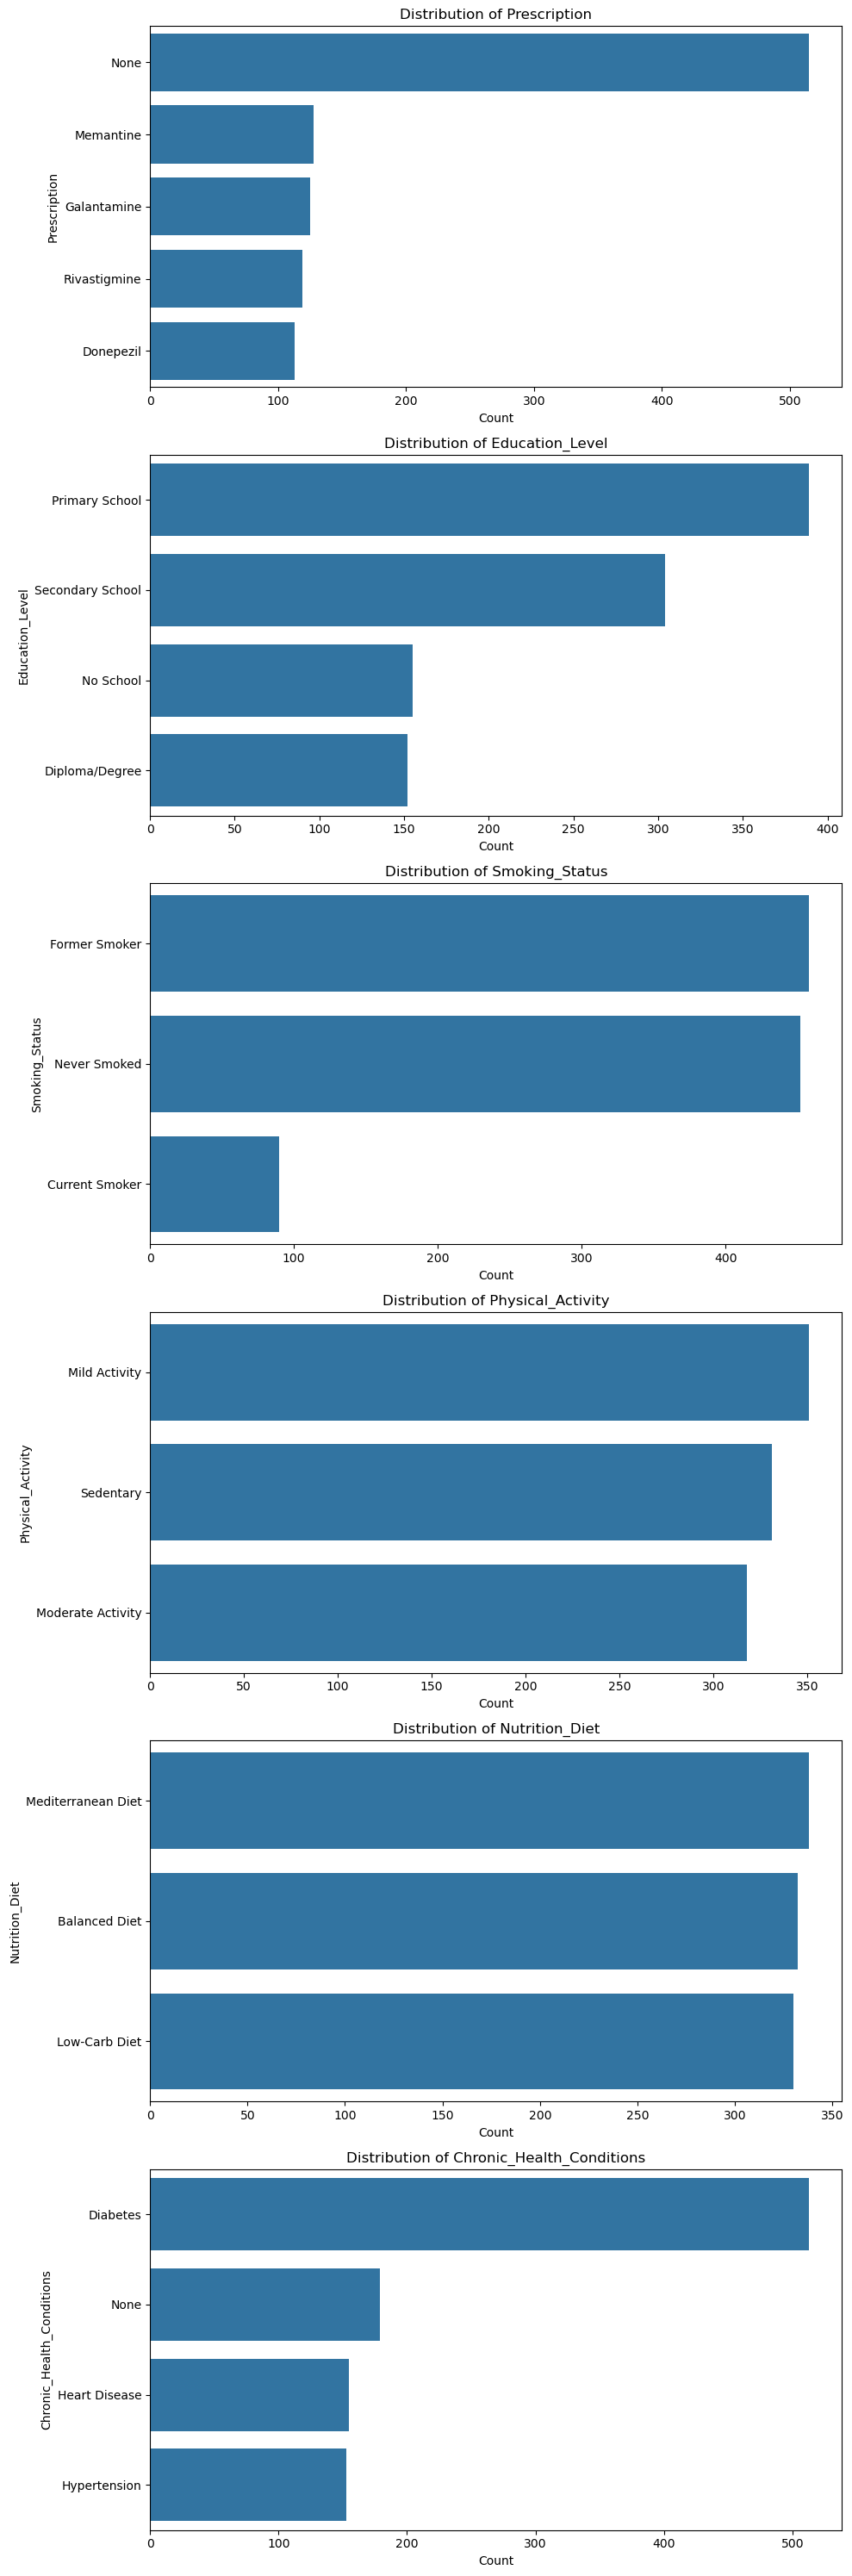

{'Prescription': Prescription
 None            515
 Memantine       128
 Galantamine     125
 Rivastigmine    119
 Donepezil       113
 Name: count, dtype: int64,
 'Education_Level': Education_Level
 Primary School      389
 Secondary School    304
 No School           155
 Diploma/Degree      152
 Name: count, dtype: int64,
 'Smoking_Status': Smoking_Status
 Former Smoker     458
 Never Smoked      452
 Current Smoker     90
 Name: count, dtype: int64,
 'Physical_Activity': Physical_Activity
 Mild Activity        351
 Sedentary            331
 Moderate Activity    318
 Name: count, dtype: int64,
 'Nutrition_Diet': Nutrition_Diet
 Mediterranean Diet    338
 Balanced Diet         332
 Low-Carb Diet         330
 Name: count, dtype: int64,
 'Chronic_Health_Conditions': Chronic_Health_Conditions
 Diabetes         513
 None             179
 Heart Disease    155
 Hypertension     153
 Name: count, dtype: int64}

In [9]:
# Set variable for all categorical variables
all_categorical_vars = df.select_dtypes(include=['object']).columns

# Set variable for the distribution of all categorical variables
all_categorical_summaries = {var: df[var].value_counts() for var in all_categorical_vars}

# Visualizing the distribution
fig, axs = plt.subplots(len(all_categorical_vars), 1, figsize=(10, 30))

# Loop through the categories
for i, var in enumerate(all_categorical_vars):
    sns.countplot(y=var, data=df, ax=axs[i], order = df[var].value_counts().index)
    axs[i].set_title(f'Distribution of {var}')
    axs[i].set_xlabel('Count')
    axs[i].set_ylabel(var)

plt.tight_layout()
plt.show()

all_categorical_summaries

### Numerical Distributions

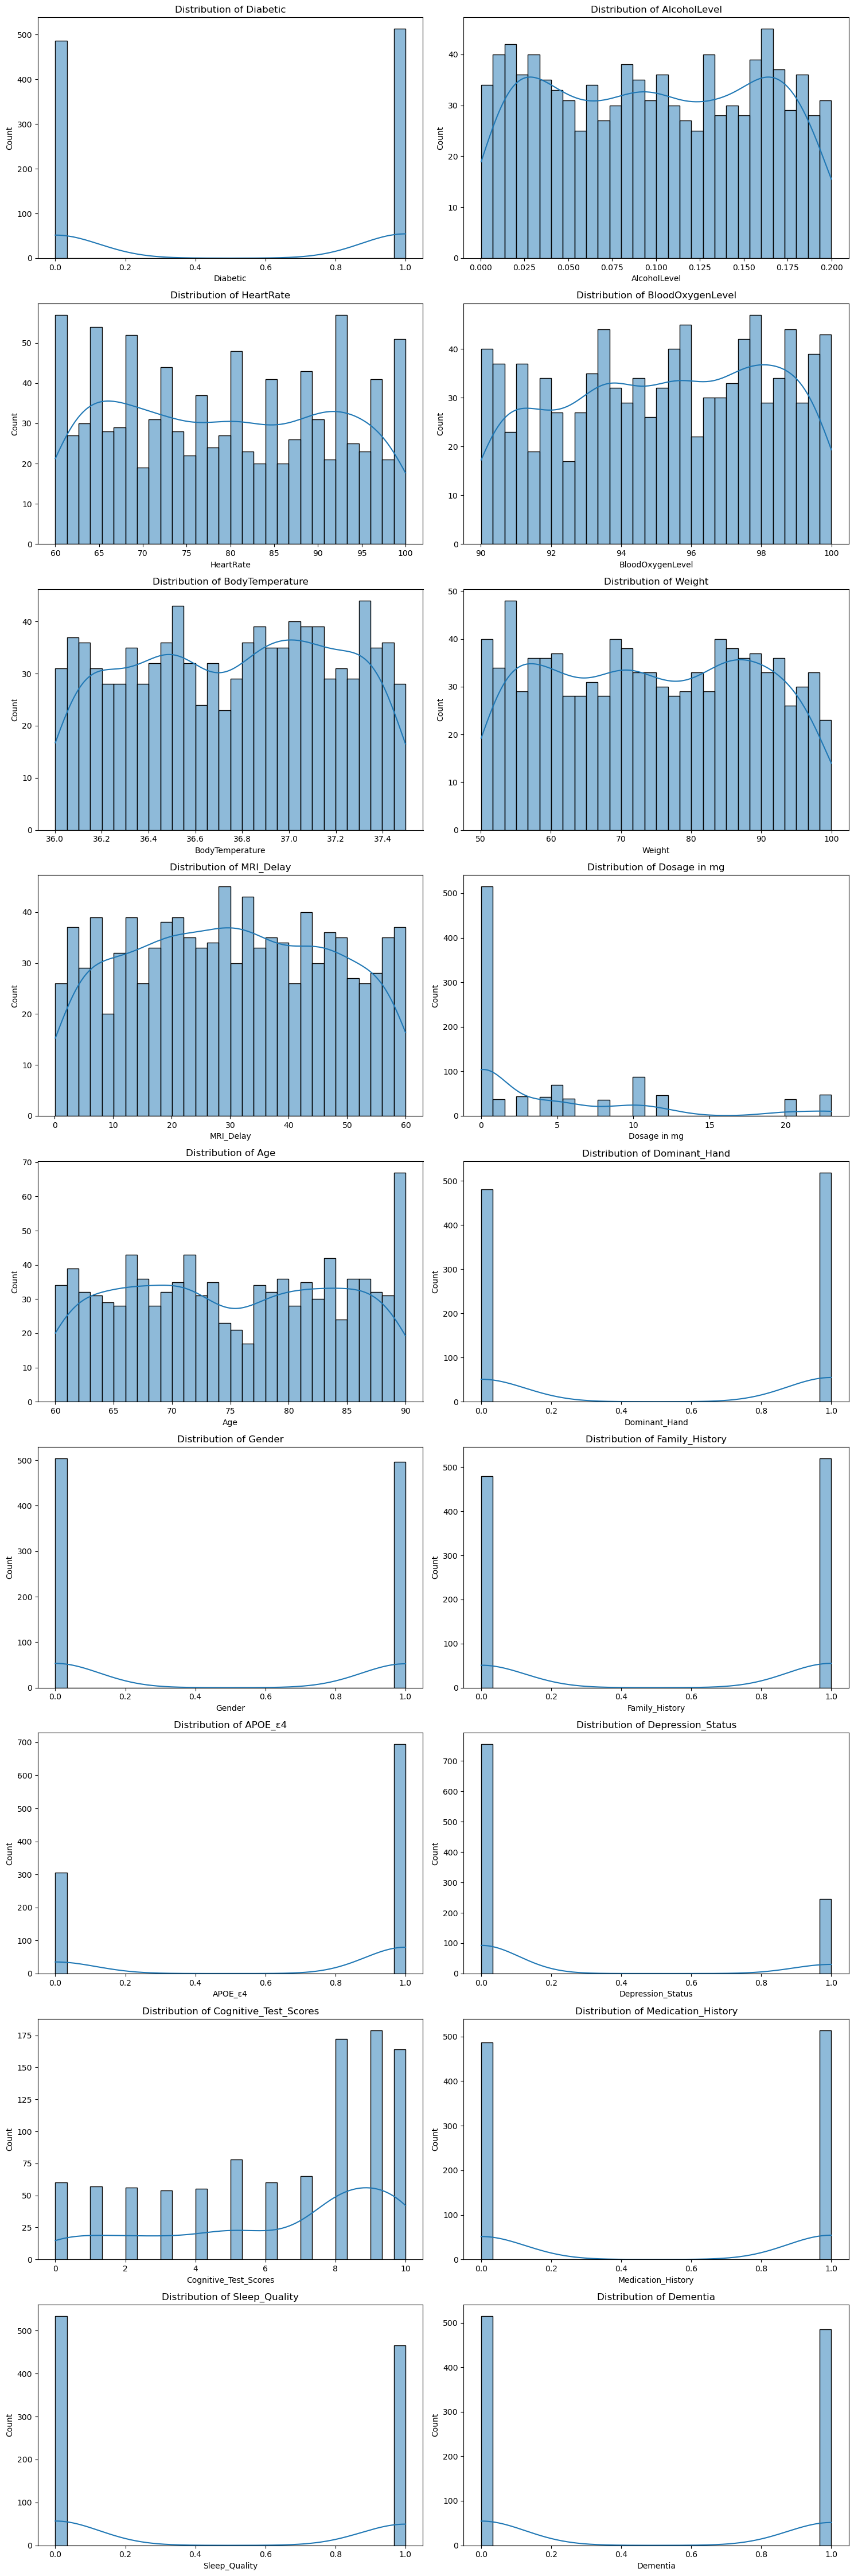

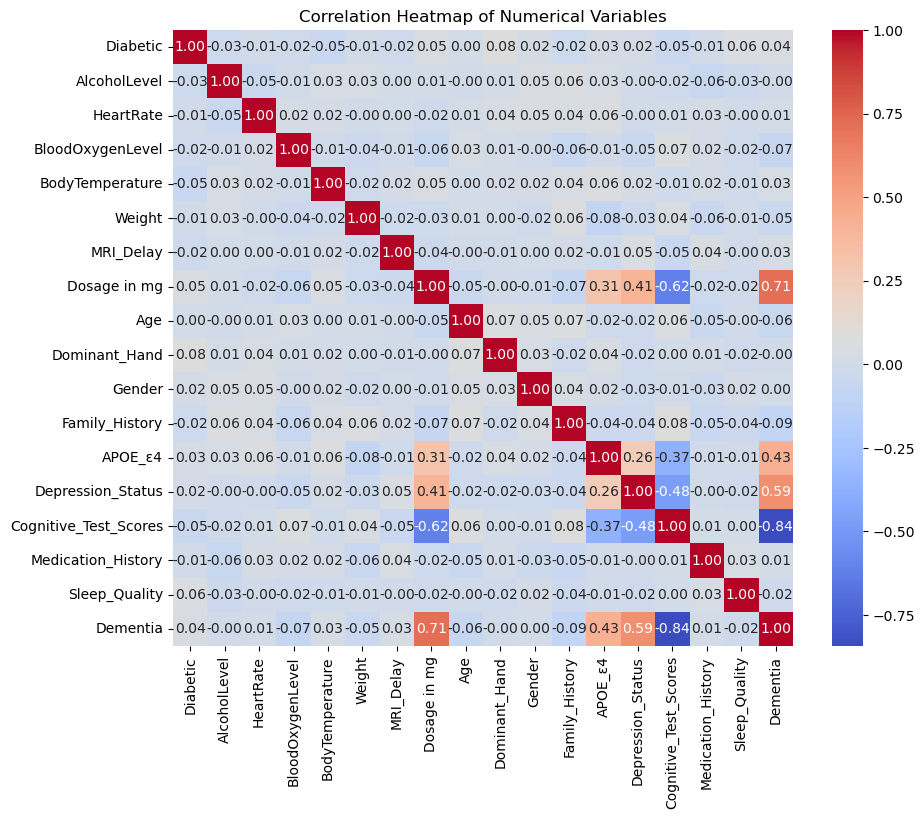

In [10]:
# Calculate the required number of rows to fit all numerical columns
num_plots = len(numerical_cols)
num_rows = (num_plots // 2) + (num_plots % 2)

# Plotting histograms for selected numerical variables
fig, axs = plt.subplots(num_rows, 2, figsize=(15, num_rows * 5))

for i, col in enumerate(numerical_cols):
    sns.histplot(df[col], ax=axs[i//2, i%2], kde=True, bins=30)
    axs[i//2, i%2].set_title(f'Distribution of {col}')

# If the number of plots is odd, hide the last subplot if unused
if num_plots % 2 != 0:
    axs[-1, -1].axis('off')

plt.tight_layout()
plt.show()

# Correlation heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(df[numerical_cols].corr(), annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Heatmap of Numerical Variables')
plt.show()

### Target Counts by Feature Values

In [11]:
# Looping through each feature to output target counts
for column in df.drop('Dementia', axis=1).columns:
    # Perform the groupby operation and count target status per value within features
    counts = df.groupby([column, 'Dementia']).size().unstack(fill_value=0)
    print(f"Feature: {column}")
    print(counts)
    print("\n-----\n")

Feature: Diabetic
Dementia    0    1
Diabetic          
0         262  225
1         253  260

-----

Feature: AlcoholLevel
Dementia      0  1
AlcoholLevel      
0.000414      0  1
0.000751      1  0
0.000949      0  1
0.001226      0  1
0.001327      1  0
...          .. ..
0.198686      1  0
0.198797      0  1
0.198963      1  0
0.198989      1  0
0.199866      1  0

[1000 rows x 2 columns]

-----

Feature: HeartRate
Dementia    0   1
HeartRate        
60         16  16
61         18   7
62         10  17
63         10  20
64         17   9
65         13  15
66         15  13
67         15  14
68         19   9
69         15   9
70          7  12
71         13  18
72         14  10
73         11   9
74         15  13
75         12  10
76          9   9
77          8  11
78         17   7
79         15  12
80         11   9
81         12  16
82         12  11
83         12   8
84         11  14
85         10   6
86          9  11
87         12  14
88          7  12
89         14  10
9

### Final Cleaning Based on EDA

In [12]:
# Remove Prescription and Dosage in mg from data set, the only values to require a dementia diagnosis.
# Remove Diabetic as it's a redundancy in Chronic_Health_Conditions
df = df.drop(['Diabetic', 'Prescription', 'Dosage in mg'], axis=1)

In [13]:
df.shape

(1000, 21)

## SQLite Database Entry

In [15]:
# SQLite database creation
import sqlite3

# Clean headers to prep for transferring into db
df.columns = df.columns.str.strip()

# Connect to SQLite
conn = sqlite3.connect('dementia.sqlite')

# Load to SQLite
df.to_sql('dementia', conn, if_exists='replace', index=True)

# Close the connection
conn.close()

## Separating Features from Target

In [ ]:
# # Separate features from target and convert categorical data
X = df.drop('Dementia', axis=1)
X = pd.get_dummies(X)
y = df['Dementia']

# Split the dataset into training (80%) and test (20%) sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)

In [ ]:
# Review features
X.head()

### StandardScaler Instance

In [ ]:
# Instantiate a StandardScaler instance
scaler = StandardScaler()

# Fit the Standard Scaler with the training data
X_scaler = scaler.fit(X_train)

# Scale the training data
X_train_scaled = X_scaler.transform(X_train)
X_test_scaled = X_scaler.transform(X_test)

## XGBoost Model

### PCA Scaling with pd.get_dummies() --- COMMENTED OUT --- n/PCA Explained Variance Ratio almost the same as n/total features

In [ ]:
# Reset X and y
# X = df.drop('Dementia', axis=1)
# y = df['Dementia']

# # Selecting numerical features for PCA
# numerical_features = X.select_dtypes(include=['float64', 'int64']).columns.tolist()
# X_numerical = X[numerical_features]

# # If you have categorical features you want to keep outside of PCA, select them here
# categorical_features = X.select_dtypes(include=['object']).columns.tolist()
# X_categorical = pd.get_dummies(X[categorical_features])


In [ ]:
# scaler = StandardScaler()
# X_scaled = scaler.fit_transform(X)

# # pca = PCA(n_components=9)
# # X_pca = pca.fit_transform(X_scaled)

# # If you have categorical features
# # X_final = np.concatenate((X_pca, X_categorical.values), axis=1)

In [ ]:
# pca.explained_variance_ratio_

In [ ]:
# sum(pca.explained_variance_ratio_)

In [ ]:
# print(X_pca)

### Initial Modeling

In [ ]:
# Confirm percentage that have dementia in data set
sum(y)/len(y)

In [ ]:
# Stratify to normalize the test and train ratios
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1, stratify=y)

In [ ]:
# Confirm training data properly stratified
sum(y_train)/len(y_train)

In [ ]:
# Confirm test data properly stratified
sum(y_test)/len(y_test)

In [ ]:
# Instantiate first model
xgb_clf = xgb.XGBClassifier(objective='binary:logistic', seed=1)
first_model = xgb_clf.fit(X_train, y_train, verbose=True, early_stopping_rounds=10, eval_metric='aucpr', eval_set=[(X_test, y_test)])

In [ ]:
# Evaluate the model
y_pred = first_model.predict(X_test)
y_pred_proba = first_model.predict_proba(X_test)[:, 1]

# Accuracy and ROC AUC Scores
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy}")
roc_auc = roc_auc_score(y_test, y_pred_proba)
print(f"ROC AUC: {roc_auc}")

In [ ]:
# Iterate through all pca components and combine them with the categorical features
# pca_feature_names = [f'PCA_Component_{i}' for i in range(1, pca.n_components_ + 1)]
# categorical_feature_names = X_categorical.columns.tolist()
# all_feature_names = pca_feature_names + categorical_feature_names
feature_names = X.columns.tolist()

# Pull the feature importance metrics from the model
importance = first_model.feature_importances_

# Output to dataframe
features_first_model = pd.DataFrame({
    'Feature': feature_names,
    'Importance': importance
}).sort_values(by='Importance', ascending=False)

features_first_model.head(40)

### Random CV Modeling

In [ ]:
# Set hyperparameters for RandomizedSearch
params = {
        'min_child_weight': [1, 5, 10],
        'gamma': [0.5, 1, 1.5, 2, 5],
        'subsample': [0.6, 0.8, 1.0],
        'colsample_bytree': [0.6, 0.8, 1.0],
        'max_depth': [3, 4, 5]
        }

In [ ]:
# Instantiate model for RandomizedSearch
xgb_clf = xgb.XGBClassifier(learning_rate=0.02, n_estimators=600, objective='binary:logistic',
                    silent=True, nthread=1)

In [ ]:
# Set variables for SKFolds and RandomizedSearch parameters
folds = 5
param_comb = 5

skf = StratifiedKFold(n_splits=folds, shuffle = True, random_state = 1001)

random_search = RandomizedSearchCV(xgb_clf, param_distributions=params, n_iter=param_comb, scoring='roc_auc', n_jobs=4, cv=skf.split(X_train, y_train), verbose=3, random_state=1001 )
random_search.fit(X_train, y_train)

In [ ]:
# Print results to pull optimal hyperparameter results
print('\n All results:')
print(random_search.cv_results_)
print('\n Best estimator:')
print(random_search.best_estimator_)
print('\n Best normalized gini score for %d-fold search with %d parameter combinations:' % (folds, param_comb))
print(random_search.best_score_ * 2 - 1)
print('\n Best hyperparameters:')
print(random_search.best_params_)


In [ ]:
# Apply results to new variable for modeling
best_params = {
    'subsample': 1.0,
    'min_child_weight': 5,
    'max_depth': 3,
    'gamma': 5,
    'colsample_bytree': 1.0,
    'learning_rate': 0.02,
    'n_estimators': 600,
    'objective': 'binary:logistic',
    'silent': True,
    'nthread': 1,
    'seed': 1
}

# Instantiate the classifier with the best parameters
optimized_xgb_clf = xgb.XGBClassifier(**best_params)

# Fit the classifier to the training data
random_xgb_clf = optimized_xgb_clf.fit(X_train, y_train, verbose=True, early_stopping_rounds=10, eval_metric='aucpr', eval_set=[(X_test, y_test)])

In [ ]:
# Evaluate the model
y_pred = random_xgb_clf.predict(X_test)
y_pred_proba = random_xgb_clf.predict_proba(X_test)[:, 1]

# Accuracy and ROC AUC Scores
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy}")
roc_auc = roc_auc_score(y_test, y_pred_proba)
print(f"ROC AUC: {roc_auc}")

In [ ]:
# Iterate through all pca components and combine them with the categorical features
# pca_feature_names = [f'PCA_Component_{i}' for i in range(1, pca.n_components_ + 1)]
# categorical_feature_names = X_categorical.columns.tolist()
# all_feature_names = pca_feature_names + categorical_feature_names
feature_names = X.columns.tolist()

# Pull the feature importance metrics from the model
importance = random_xgb_clf.feature_importances_

# Output to dataframe
features_random_model = pd.DataFrame({
    'Feature': feature_names,
    'Importance': importance
}).sort_values(by='Importance', ascending=False)

features_random_model.head(40)

### Grid Search CV Modeling

In [ ]:
# Instantiate the model for GridSearch
xgb_clf = xgb.XGBClassifier(learning_rate=0.02, n_estimators=600, objective='binary:logistic', silent=True, nthread=1)

# Set hyperparameters to variable
params = {
    'min_child_weight': [1, 5, 10],
    'gamma': [0.5, 1, 1.5, 2],
    'subsample': [0.6, 0.8, 1.0],
    'colsample_bytree': [0.6, 0.8, 1.0],
    'max_depth': [3, 4, 5]
}

In [ ]:
# Set variables for SKFolds and GridSearch parameters
folds = 5
skf = StratifiedKFold(n_splits=folds, shuffle=True, random_state=42)

grid_search = GridSearchCV(xgb_clf, param_grid=params, scoring='roc_auc', n_jobs=-1, cv=skf, verbose=3)

In [ ]:
# Fit the GridSearch to the data
grid_search.fit(X_train, y_train)

In [ ]:
# Print the results of the optimal hyperparameters
print("Best parameters found: ", grid_search.best_params_)
print("Best AUC score found: ", grid_search.best_score_)

In [ ]:
# Assign variable to the best model
best_model = grid_search.best_estimator_

In [ ]:
# Evaluate the model
y_pred = best_model.predict(X_test)
y_pred_proba = best_model.predict_proba(X_test)[:, 1]

accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy}")

# Calculate ROC AUC
roc_auc = roc_auc_score(y_test, y_pred_proba)
print(f"ROC AUC: {roc_auc}")

In [ ]:
# Iterate through all pca components and combine them with the categorical features
# pca_feature_names = [f'PCA_Component_{i}' for i in range(1, pca.n_components_ + 1)]
# categorical_feature_names = X_categorical.columns.tolist()
# all_feature_names = pca_feature_names + categorical_feature_names
feature_names = X.columns.tolist()

# Pull the feature importance metrics from the model
importance = best_model.feature_importances_

# Output to dataframe
features_best_model = pd.DataFrame({
    'Feature': feature_names,
    'Importance': importance
}).sort_values(by='Importance', ascending=False)

features_best_model.head(40)

In [ ]:
print(confusion_matrix(y_test, y_pred))

In [ ]:
print(classification_report(y_test, y_pred))

In [ ]:
plt.figure(figsize=(20, 20))  # Adjust figure size
xgb.plot_tree(best_model, num_trees=0)
plt.savefig('tree_high_res.png', dpi=300)
plt.close()

In [ ]:
xgb.plot_importance(best_model)
plt.show()

In [ ]:
plt.figure(figsize=(12, 8))  # Set a larger figure size to accommodate all features
xgb.plot_importance(best_model, height=0.5, grid=False, show_values=True)  # Removed max_num_features to show all
plt.title('Feature Importance', fontsize=16)  # Add a title
plt.xlabel('F score', fontsize=14)  # Set x-axis label
plt.ylabel('Features', fontsize=14)  # Set y-axis label
plt.yticks(fontsize=10)  # Set the font size of y-axis ticks
plt.xticks(fontsize=10)  # Set the font size of x-axis ticks
plt.tight_layout()  # Adjust the layout
plt.show()

## Sagemaker Deployment

In [ ]:
# Import Sagemaker dependencies
import sagemaker
import boto3
from sagemaker import get_execution_role
from sagemaker.inputs import TrainingInput
from sagemaker.serializers import CSVSerializer
from sagemaker.deserializers import CSVDeserializer
from sagemaker.xgboost.model import XGBoostModel
from sklearn.metrics import mean_squared_error, r2_score

sm_boto3 = boto3.client("sagemaker", region_name='us-east-1')
sess = sagemaker.Session()
region = sess.boto_session.region_name
bucket = 'dementia-xgboost-pca-model-dcasey07'
print("Using bucket " + bucket)

In [ ]:
y_train_array = y_train.to_numpy().reshape(-1, 1)
y_test_array = y_test.to_numpy().reshape(-1, 1)

X_y_train = np.concatenate([y_train_array, X_train], axis=1)
df_train = pd.DataFrame(X_y_train)

X_y_test = np.concatenate([y_test_array, X_test], axis=1)
df_test = pd.DataFrame(X_y_test)

# Function to convert DataFrame to LIBSVM format
def convert_to_libsvm(df, filename):
    with open(filename, 'w') as f:
        for _, row in df.iterrows():
            libsvm_string = str(int(row[0]))  # Target variable
            for index, value in enumerate(row[1:], start=1):
                if value != 0:  # Only include non-zero features
                    libsvm_string += f" {index}:{value}"
            f.write(libsvm_string + "\n")

# Convert and save the training and test sets
convert_to_libsvm(df_train, "train_libsvm.txt")
convert_to_libsvm(df_test, "test_libsvm.txt")

In [ ]:
# Upload data to S3 bucket
sk_prefix = "sagemaker/dementia_model_classification/xgboost_container"
trainpath = sess.upload_data(
    path="train_libsvm.txt", bucket=bucket, key_prefix=sk_prefix
)

testpath = sess.upload_data(
    path="test_libsvm.txt", bucket=bucket, key_prefix=sk_prefix
)

# Confirm pathing
print(trainpath)
print(testpath)

In [ ]:
best_model.get_params()

In [ ]:
import sagemaker
import boto3
from sagemaker import image_uris
from sagemaker.session import Session
from sagemaker.inputs import TrainingInput
import os

role = os.environ.get('SAGEMAKER_ROLE_ARN', get_execution_role())

# initialize hyperparameters
hyperparameters = {
    'objective': 'binary:logistic',
    'colsample_bytree': 0.6,
    'gamma': 0.5,
    'learning_rate': 0.02,
    'max_depth': 3,
    'min_child_weight': 1,
    'subsample': 0.6,
    'num_round': 600,
    'verbosity': 0
}

# set an output path where the trained model will be saved
output_path = 's3://{}/{}/{}/output'.format(bucket, sk_prefix, 'dementia-xgb-algo')

# this line automatically looks for the XGBoost image URI and builds an XGBoost container.
# specify the repo_version depending on your preference.
xgboost_container = sagemaker.image_uris.retrieve("xgboost", region, "1.7-1")

# construct a SageMaker estimator that calls the xgboost-container
estimator = sagemaker.estimator.Estimator(image_uri=xgboost_container, 
                                          hyperparameters=hyperparameters,
                                          role=role,
                                          instance_count=1, 
                                          instance_type='ml.m5.large', 
                                          volume_size=5, # 5 GB 
                                          output_path=output_path)

# define the data type and paths to the training and validation datasets
content_type = "LIBSVM"
train_input = TrainingInput("s3://dementia-xgboost-pca-model-dcasey07/sagemaker/dementia_model_classification/xgboost_container/train_libsvm.txt")
validation_input = TrainingInput("s3://dementia-xgboost-pca-model-dcasey07/sagemaker/dementia_model_classification/xgboost_container/test_libsvm.txt")

# execute the XGBoost training job
estimator.fit({'train': train_input, 'validation': validation_input})


In [ ]:
predictor = estimator.deploy(initial_instance_count=1, instance_type='ml.m5.large')

In [ ]:
from sagemaker.serializers import CSVSerializer
predictor.serializer = CSVSerializer()

In [ ]:
from sagemaker.deserializers import JSONDeserializer
predictor.deserializer = JSONDeserializer()

In [ ]:
X_test = X_test.astype(float)
# Convert the numpy array to a CSV string

In [ ]:
test_sample = X_test[:30]
csv_test_sample = '\n'.join([','.join(str(x) for x in sample) for sample in test_sample])
results = predictor.predict(test_sample)
print(results) 

In [ ]:
predictions = [pred['score'] for pred in results['predictions']]

In [ ]:
y_test_array = np.array(y_test[:30])
predictions_array = np.array(predictions)

In [ ]:
# Plotting predicted vs. actual values
plt.plot(np.array(y_test_array), label="actual")
plt.plot(predictions, label="predict")
plt.legend()
plt.show()

In [ ]:
# Calculating the RMSE and R2 scores
rmse = np.sqrt(mean_squared_error(y_test_array, predictions))
r2 = r2_score(y_test_array, predictions)

print("RMSE:", rmse)
print("R2 score:", r2)

In [ ]:
predictor.delete_endpoint()